In [ ]:
!pip install pyspark

In [ ]:
from pyspark.sql import SparkSession

# Démarrer la session Spark
spark = SparkSession.builder.appName("PySpark ML Pipeline").getOrCreate()

df = spark.read.format("csv").option("header", "true").option("inferSchema", "true").load("/content/heart-disease-68ec37d6b52cb588200595.csv")


In [ ]:
df = df.replace("?", None).dropna()


print("Rows dropped:", spark.read.format("csv").option("header", "true").option("inferSchema", "true").load("/content/heart-disease-68ec37d6b52cb588200595.csv").count() - df.count())



df.describe().show()


Rows dropped: 6
+-------+------------------+-----------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+-----------------+------------------+
|summary|                ID|              Age|               Sex|            Angina|    Blood_Pressure|       Cholesterol|          Glycemia|               ECG|        Heart_Rate|Angina_After_Sport|        ECG_Angina|         ECG_Slope|       Fluoroscopy|     Thalassaemia|           Disease|
+-------+------------------+-----------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+-----------------+------------------+
|  count|               297|              297|               297|               297|               297|  

In [ ]:
for name, dtype in df.dtypes:
    print(f"{name}: {dtype}")


ID: int
Age: double
Sex: double
Angina: double
Blood_Pressure: double
Cholesterol: double
Glycemia: double
ECG: double
Heart_Rate: double
Angina_After_Sport: double
ECG_Angina: double
ECG_Slope: double
Fluoroscopy: string
Thalassaemia: string
Disease: int


In [ ]:
from pyspark.sql.functions import when, col

df = df.withColumn("Sex", when(col("Sex") == 0, "Female").otherwise("Male"))

df = df.withColumn("angina", when(col("Angina") == 1, "Stable angina")
    .when(col("Angina") == 2, "Unstable angina")
    .when(col("Angina") == 3, "Other pains")
    .when(col("Angina") == 4, "Asymptomatic")
    .otherwise("Unknown"))

df = df.withColumn("Glycemia", when(col("Glycemia") == 0, "Less than 120 mg/dl").when(col("Glycemia") == 1, "More than 120 mg/dl").otherwise("UnKnown"))
df = df.withColumn("ECG", when(col("ECG") == 0, "Normal").when(col("ECG") == 1, "Anomalies").when(col("ECG") == 2, "Hypertrophy").otherwise("UnKnown"))
df = df.withColumn("angina_after_sport", when(col("Angina_After_Sport") == 0, "No")
    .when(col("Angina_After_Sport") == 1, "Yes")
    .otherwise("Unknown")
)


df = df.withColumn("ecg_slope",
    when(col("ECG_Slope") == 1, "Rising")
    .when(col("ECG_Slope") == 2, "Stable")
    .when(col("ECG_Slope") == 3, "Falling")
    .otherwise("Unknown")
)



df = df.withColumn("fluoroscopy",
    when(col("Fluoroscopy") == 0, "No anomaly")
    .when(col("Fluoroscopy") == 1, "Low")
    .when(col("Fluoroscopy") == 2, "Medium")
    .when(col("Fluoroscopy") == 3, "High")
    .otherwise("Unknown")
)


df = df.withColumn("thalassemia",
    when(col("Thalassaemia") == 3, "No")
    .when(col("Thalassaemia") == 6, "Thalassaemia under control")
    .when(col("Thalassaemia") == 7, "Unstable Thalassaemia")
    .otherwise("Unknown")
)


df = df.withColumn(
    "disease",
    when(col("Disease") == 0, "No").otherwise("Yes")
)


df.show()


+---+----+------+---------------+--------------+-----------+-------------------+-----------+----------+------------------+----------+---------+-----------+------------+-------+--------------------+
| ID| Age|   Sex|         angina|Blood_Pressure|Cholesterol|           Glycemia|        ECG|Heart_Rate|angina_after_sport|ECG_Angina|ecg_slope|fluoroscopy|Thalassaemia|disease|         thalassemia|
+---+----+------+---------------+--------------+-----------+-------------------+-----------+----------+------------------+----------+---------+-----------+------------+-------+--------------------+
|  1|63.0|  Male|  Stable angina|         145.0|      233.0|More than 120 mg/dl|Hypertrophy|     150.0|                No|       2.3|  Falling| No anomaly|         6.0|     No|Thalassaemia unde...|
|  2|67.0|  Male|   Asymptomatic|         160.0|      286.0|Less than 120 mg/dl|Hypertrophy|     108.0|               Yes|       1.5|   Stable|       High|         3.0|    Yes|                  No|
|  3|67.0|

In [ ]:

df.groupBy("sex").count().show()
df.groupBy("angina").count().show()
df.groupBy("Glycemia").count().show()
df.groupBy("ECG").count().show()
df.groupBy("angina_after_sport").count().show()
df.groupBy("ecg_slope").count().show()
df.groupBy("fluoroscopy").count().show()
df.groupBy("thalassemia").count().show()
df.groupBy("disease").count().show()


+------+-----+
|   sex|count|
+------+-----+
|Female|   96|
|  Male|  201|
+------+-----+

+---------------+-----+
|         angina|count|
+---------------+-----+
|    Other pains|   83|
|Unstable angina|   49|
|  Stable angina|   23|
|   Asymptomatic|  142|
+---------------+-----+

+-------------------+-----+
|           Glycemia|count|
+-------------------+-----+
|More than 120 mg/dl|   43|
|Less than 120 mg/dl|  254|
+-------------------+-----+

+-----------+-----+
|        ECG|count|
+-----------+-----+
|  Anomalies|    4|
|     Normal|  147|
|Hypertrophy|  146|
+-----------+-----+

+------------------+-----+
|angina_after_sport|count|
+------------------+-----+
|                No|  200|
|               Yes|   97|
+------------------+-----+

+---------+-----+
|ecg_slope|count|
+---------+-----+
|  Falling|   21|
|   Rising|  139|
|   Stable|  137|
+---------+-----+

+-----------+-----+
|fluoroscopy|count|
+-----------+-----+
|       High|   20|
| No anomaly|  174|
|        Low|   

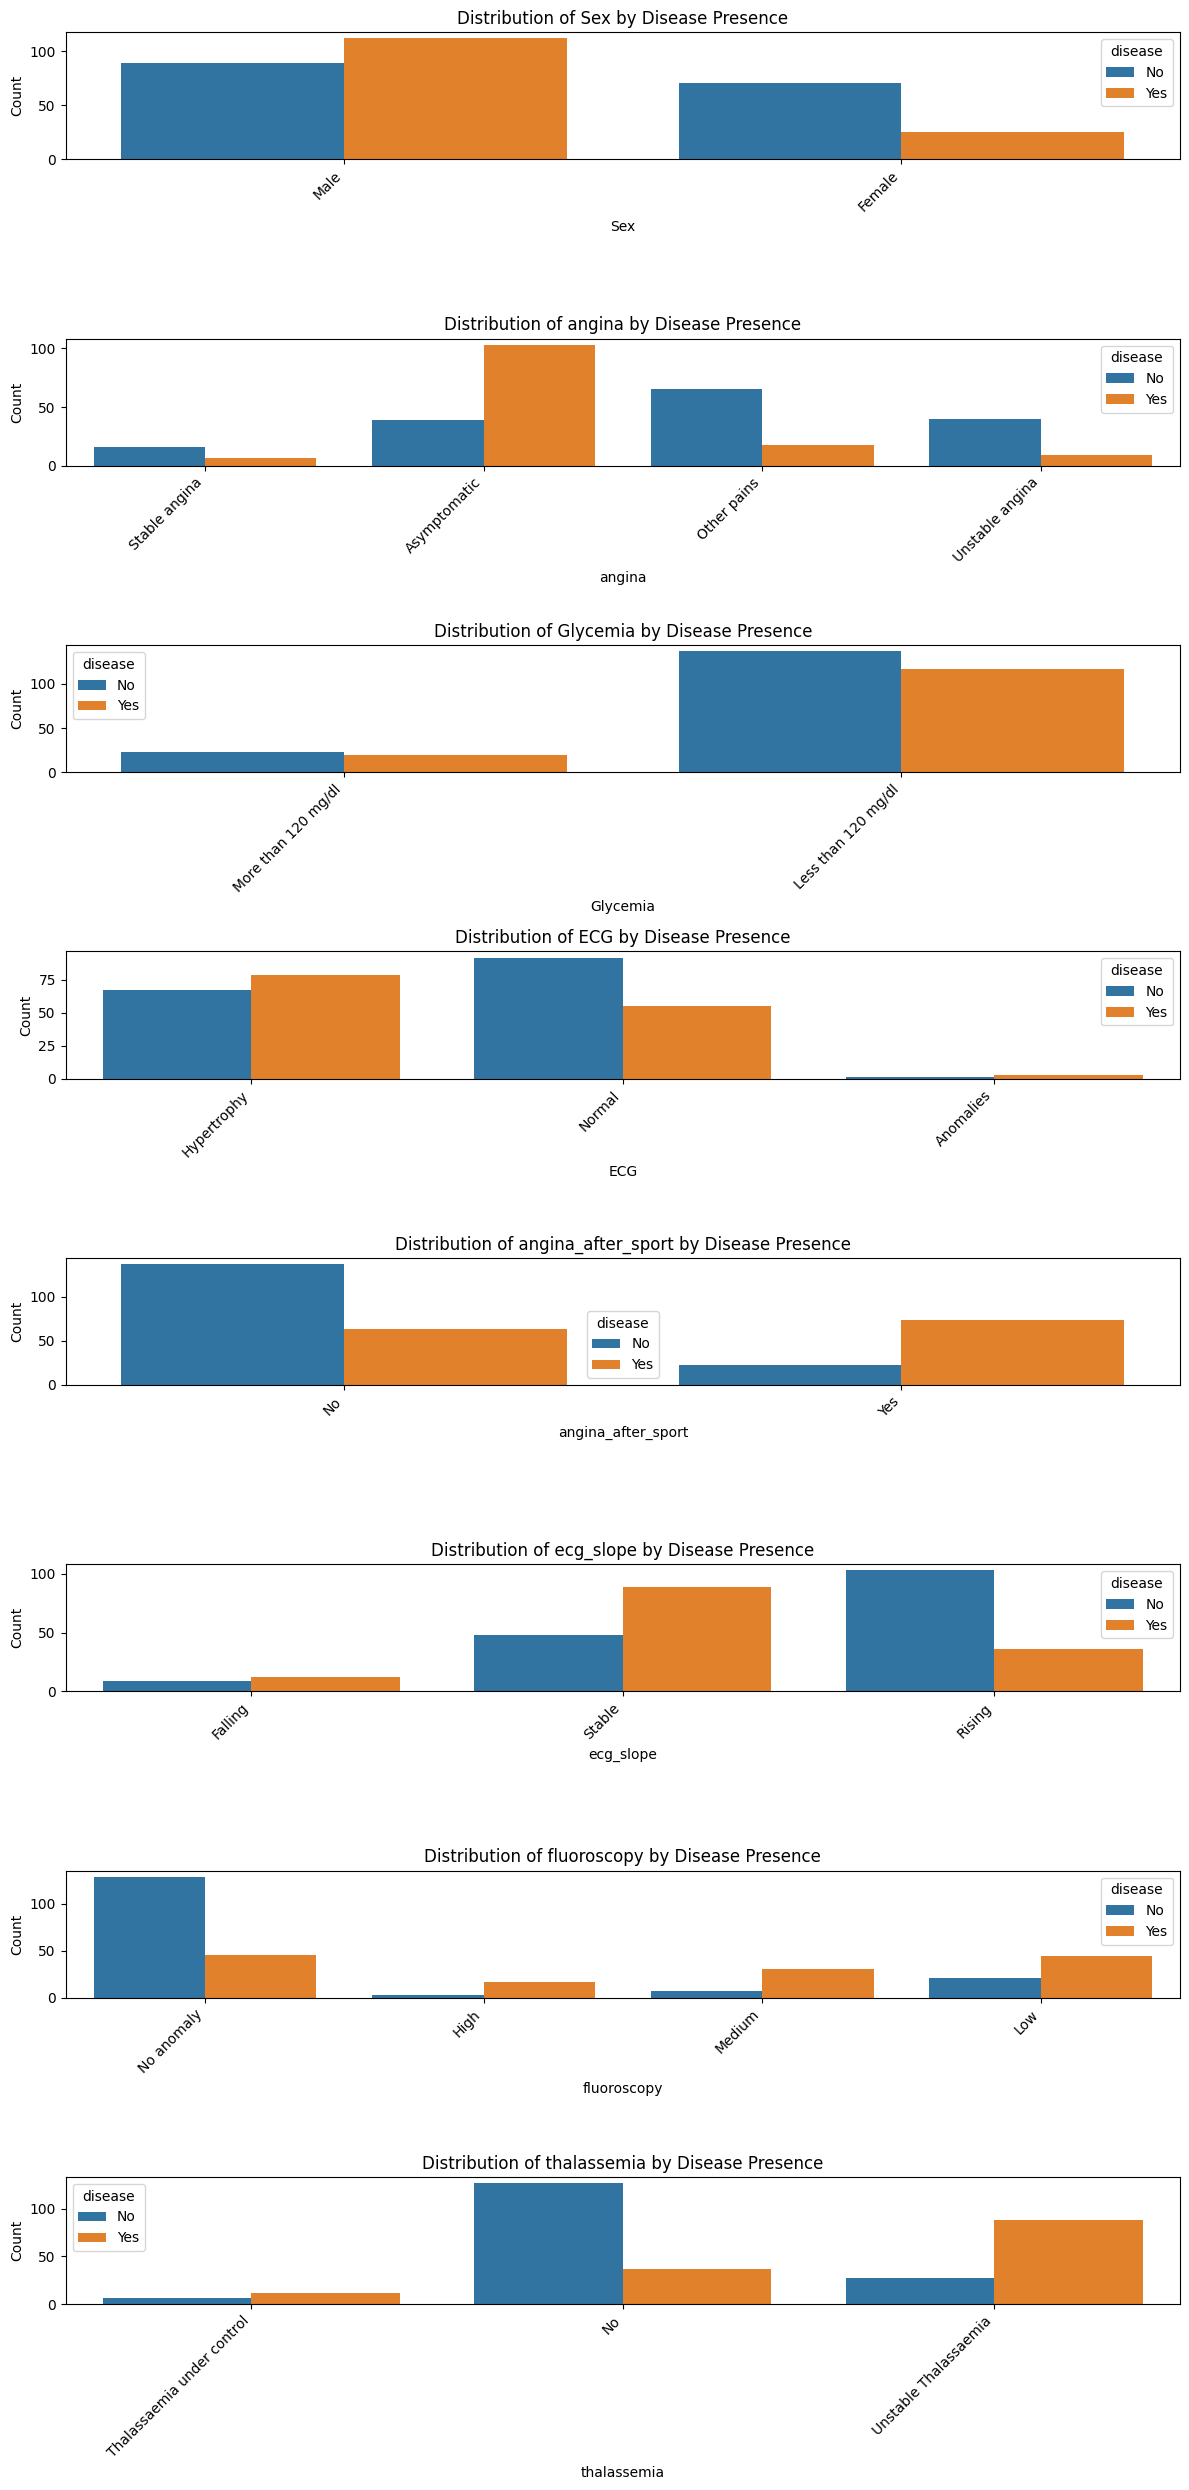

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

df_categorical_features= ["Sex","angina","Glycemia","ECG","angina_after_sport","ecg_slope","fluoroscopy","thalassemia"]


df_pandas = df.toPandas()


plt.figure(figsize=(12, 25))
for i, feature in enumerate(df_categorical_features):
    plt.subplot(len(df_categorical_features), 1, i + 1)
    sns.countplot(x=feature, hue="disease", data=df_pandas)
    plt.title(f"Distribution of {feature} by Disease Presence")
    plt.xlabel(feature)
    plt.ylabel("Count")
    plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

In [ ]:
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator


label_indexer = StringIndexer(inputCol="disease", outputCol="label", handleInvalid='skip')


sex_indexer = StringIndexer(inputCol="Sex", outputCol="Sex_idx", handleInvalid='keep')
angina_indexer = StringIndexer(inputCol="angina", outputCol="Angina_idx", handleInvalid='keep')
glycemia_indexer = StringIndexer(inputCol="Glycemia", outputCol="Glycemia_idx", handleInvalid='keep')
ecg_indexer = StringIndexer(inputCol="ECG", outputCol="ECG_idx", handleInvalid="keep")
angina_after_sport_indexer = StringIndexer(inputCol="angina_after_sport", outputCol="angina_after_sport_idx", handleInvalid="keep")
ecg_slope_indexer = StringIndexer(inputCol="ecg_slope", outputCol="ecg_slope_idx", handleInvalid="keep")
fluoroscopy_indexer = StringIndexer(inputCol="fluoroscopy", outputCol="fluoroscopy_idx", handleInvalid="keep")
thalassemia_indexer = StringIndexer(inputCol="thalassemia", outputCol="thalassemia_idx", handleInvalid="keep")


feature_columns = ["Age", "Blood_Pressure", "Cholesterol", "Heart_Rate",
                   "Sex_idx", "Angina_idx", "Glycemia_idx", "ECG_idx", "angina_after_sport_idx", "ecg_slope_idx", "fluoroscopy_idx", "thalassemia_idx"]

assembler = VectorAssembler(inputCols=feature_columns, outputCol="features", handleInvalid="skip")

lr = LogisticRegression(featuresCol="features", labelCol="label")
rf = RandomForestClassifier(featuresCol='features', labelCol='label', numTrees=100)
gbt = GBTClassifier(featuresCol='features', labelCol='label', maxIter=100)


pipeline = Pipeline(stages=[
    label_indexer,
    sex_indexer,
    angina_indexer,
    glycemia_indexer,
    ecg_indexer,
    angina_after_sport_indexer,
    ecg_slope_indexer,
    fluoroscopy_indexer,
    thalassemia_indexer,
    assembler,
    lr
])


pipeline_rf = Pipeline(stages=[
    label_indexer, sex_indexer, angina_indexer, glycemia_indexer, ecg_indexer,
    angina_after_sport_indexer, ecg_slope_indexer, fluoroscopy_indexer,
    thalassemia_indexer, assembler, rf
])


pipeline_gbt = Pipeline(stages=[
    label_indexer, sex_indexer, angina_indexer, glycemia_indexer, ecg_indexer,
    angina_after_sport_indexer, ecg_slope_indexer, fluoroscopy_indexer,
    thalassemia_indexer, assembler, gbt
])


train, test = df.randomSplit([0.7, 0.3], seed=42)

model = pipeline.fit(train)
predictions = model.transform(test)

model_rf = pipeline_rf.fit(train)
predictions_rf = model_rf.transform(test)

model_gbt = pipeline_gbt.fit(train)
predictions_gbt = model_gbt.transform(test)


evaluator = BinaryClassificationEvaluator(labelCol="label")


accuracy_rf = evaluator.evaluate(predictions_rf)
accuracy_gbt = evaluator.evaluate(predictions_gbt)

print("Random Forest Accuracy:", accuracy_rf)
print("GBT Accuracy:", accuracy_gbt)


evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Accuracy:", accuracy)

Random Forest Accuracy: 0.9041666666666668
GBT Accuracy: 0.8534722222222223
Accuracy: 0.8311688311688312


In [ ]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Calcul des métriques
evaluator_f1 = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")
evaluator_prec = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="precisionByLabel")
evaluator_recall = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="recallByLabel")


f1 = evaluator_f1.evaluate(predictions)
precision = evaluator_prec.evaluate(predictions)
recall = evaluator_recall.evaluate(predictions)


print(f"F1-score: {f1}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")


F1-score: 0.8321967226076815
Precision: 0.7317073170731707
Recall: 0.9375


In [ ]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

evaluator_f1 = MulticlassClassificationEvaluator(labelCol="indexedLabel", predictionCol="prediction", metricName="f1")
evaluator_precision = MulticlassClassificationEvaluator(labelCol="indexedLabel", predictionCol="prediction", metricName="precisionByLabel")
evaluator_recall = MulticlassClassificationEvaluator(labelCol="indexedLabel", predictionCol="prediction", metricName="recallByLabel")


f1_rf = evaluator.evaluate(predictions_rf)
precision_rf = evaluator.evaluate(predictions_rf)
recall_rf = evaluator.evaluate(predictions_rf)

print('Random Forest F1-score:', f1_rf)
print('Random Forest Precision:', precision_rf)
print('Random Forest Recall:', recall_rf)


f1_gbt = evaluator.evaluate(predictions_gbt)
precision_gbt = evaluator.evaluate(predictions_gbt)
recall_gbt = evaluator.evaluate(predictions_gbt)

print('Gradient Boosted Trees F1-score:', f1_gbt)
print('Gradient Boosted Trees Precision:', precision_gbt)
print('Gradient Boosted Trees Recall:', recall_gbt)

Random Forest F1-score: 0.8051948051948052
Random Forest Precision: 0.8051948051948052
Random Forest Recall: 0.8051948051948052
Gradient Boosted Trees F1-score: 0.7792207792207793
Gradient Boosted Trees Precision: 0.7792207792207793
Gradient Boosted Trees Recall: 0.7792207792207793


/usr/local/lib/python3.12/dist-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


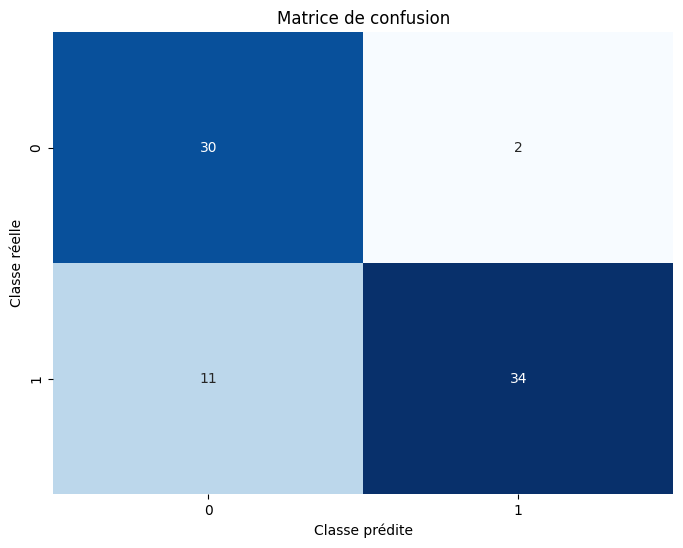

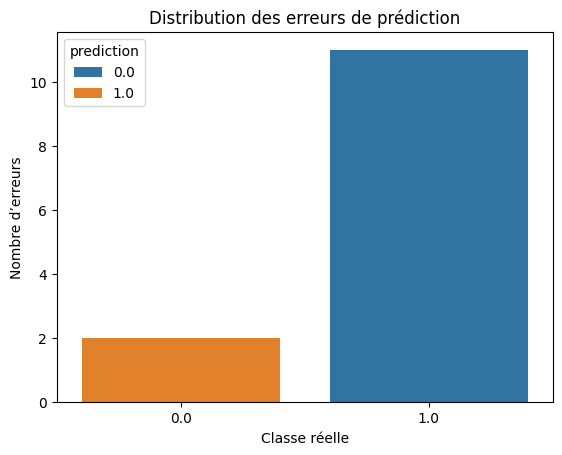

In [ ]:
from pyspark.mllib.evaluation import MulticlassMetrics
import matplotlib.pyplot as plt
import seaborn as sns


rdd = predictions.select('prediction', 'label').rdd.map(lambda row: (row['prediction'], row['label']))
metrics = MulticlassMetrics(rdd)
mat_conf = metrics.confusionMatrix().toArray()

plt.figure(figsize=(8,6))
sns.heatmap(mat_conf, annot=True, fmt='g', cmap='Blues', cbar=False)
plt.xlabel('Classe prédite')
plt.ylabel('Classe réelle')
plt.title('Matrice de confusion')
plt.show()


errors_df = predictions.filter('label != prediction').toPandas()
sns.countplot(x='label', hue='prediction', data=errors_df)
plt.title('Distribution des erreurs de prédiction')
plt.xlabel('Classe réelle')
plt.ylabel("Nombre d’erreurs")
plt.show()

/usr/local/lib/python3.12/dist-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


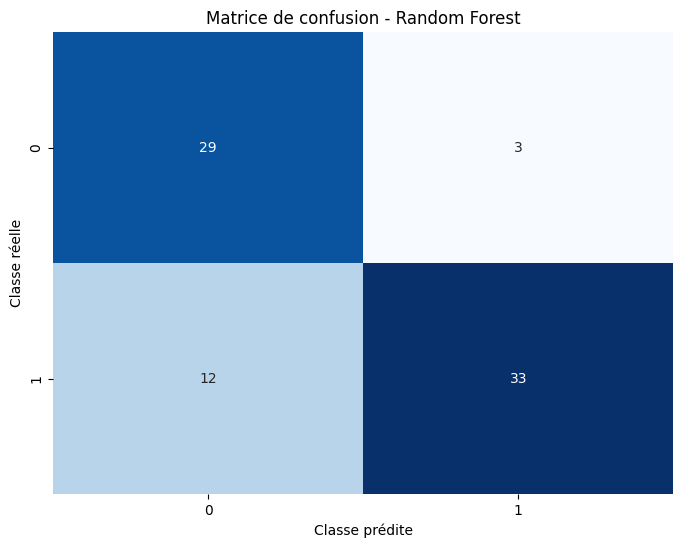

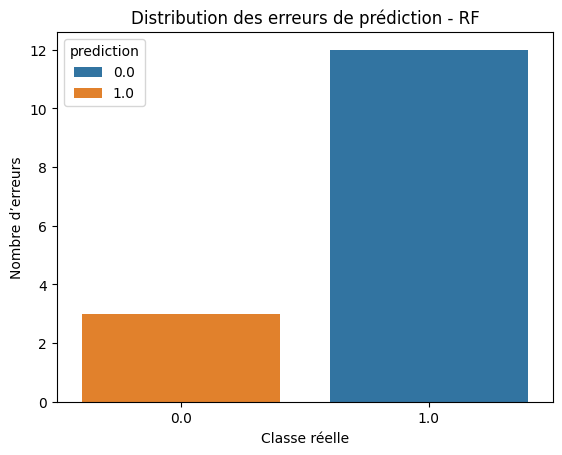

/usr/local/lib/python3.12/dist-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


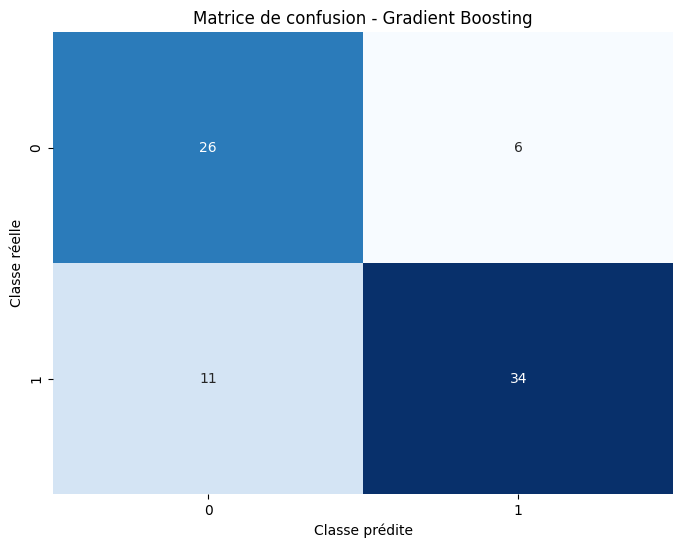

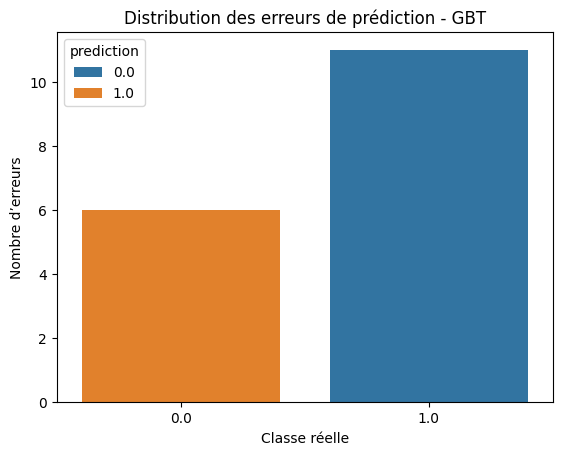

In [ ]:
from pyspark.mllib.evaluation import MulticlassMetrics
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql.types import DoubleType
from pyspark.sql.functions import col

# Pour Random Forest
rdd_rf = predictions_rf.select('prediction', 'label').rdd.map(lambda row: (float(row['prediction']), float(row['label'])))
metrics_rf = MulticlassMetrics(rdd_rf)
mat_conf_rf = metrics_rf.confusionMatrix().toArray()

plt.figure(figsize=(8,6))
sns.heatmap(mat_conf_rf, annot=True, fmt='g', cmap='Blues', cbar=False)
plt.xlabel('Classe prédite')
plt.ylabel('Classe réelle')
plt.title('Matrice de confusion - Random Forest')
plt.show()

errors_rf = predictions_rf.filter('label != prediction').toPandas()
sns.countplot(x='label', hue='prediction', data=errors_rf)
plt.title('Distribution des erreurs de prédiction - RF')
plt.xlabel('Classe réelle')
plt.ylabel("Nombre d’erreurs")
plt.show()

# Pour Gradient Boosting
rdd_gbt = predictions_gbt.select('prediction', 'label').rdd.map(lambda row: (float(row['prediction']), float(row['label'])))
metrics_gbt = MulticlassMetrics(rdd_gbt)
mat_conf_gbt = metrics_gbt.confusionMatrix().toArray()

plt.figure(figsize=(8,6))
sns.heatmap(mat_conf_gbt, annot=True, fmt='g', cmap='Blues', cbar=False)
plt.xlabel('Classe prédite')
plt.ylabel('Classe réelle')
plt.title('Matrice de confusion - Gradient Boosting')
plt.show()

errors_gbt = predictions_gbt.filter('label != prediction').toPandas()
sns.countplot(x='label', hue='prediction', data=errors_gbt)
plt.title('Distribution des erreurs de prédiction - GBT')
plt.xlabel('Classe réelle')
plt.ylabel("Nombre d’erreurs")
plt.show()

In [125]:
import numpy as np
import pandas as pd


lr_model = model.stages[-1]


coefficients = np.array(lr_model.coefficients)


feature_names = assembler.getInputCols()


coef_df = pd.DataFrame({
    'feature': feature_names,
    'coefficient': coefficients,
    'abs_coefficient': np.abs(coefficients)
})


coef_df = coef_df.sort_values(by='abs_coefficient', ascending=False).reset_index(drop=True)

print(coef_df)


                   feature  coefficient  abs_coefficient
0             Glycemia_idx    -1.666091         1.666091
1                  Sex_idx    -1.577426         1.577426
2   angina_after_sport_idx     1.160339         1.160339
3          fluoroscopy_idx     1.135092         1.135092
4          thalassemia_idx     0.813035         0.813035
5               Angina_idx    -0.694052         0.694052
6            ecg_slope_idx     0.504222         0.504222
7                  ECG_idx     0.373763         0.373763
8           Blood_Pressure     0.022006         0.022006
9               Heart_Rate    -0.019131         0.019131
10                     Age    -0.009604         0.009604
11             Cholesterol     0.004530         0.004530


In [123]:
import pandas as pd

rf_model = model_rf.stages[-1]


importances = rf_model.featureImportances


feature_names = assembler.getInputCols()


importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances.toArray()
})


importance_df.sort_values(by="importance", ascending=False, inplace=True)

print(importance_df)


                   feature  importance
5               Angina_idx    0.230725
11         thalassemia_idx    0.145401
3               Heart_Rate    0.126802
10         fluoroscopy_idx    0.106933
0                      Age    0.097312
8   angina_after_sport_idx    0.072035
1           Blood_Pressure    0.070118
2              Cholesterol    0.053686
9            ecg_slope_idx    0.042934
4                  Sex_idx    0.032153
7                  ECG_idx    0.012181
6             Glycemia_idx    0.009719


In [124]:
gbt_model = model_gbt.stages[-1]


importances = gbt_model.featureImportances


feature_names = assembler.getInputCols()


importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances.toArray()
})

importance_df.sort_values(by="importance", ascending=False, inplace=True)

print(importance_df)


                   feature  importance
3               Heart_Rate    0.164419
0                      Age    0.142554
5               Angina_idx    0.137043
11         thalassemia_idx    0.123055
2              Cholesterol    0.107594
1           Blood_Pressure    0.106314
10         fluoroscopy_idx    0.084915
9            ecg_slope_idx    0.056320
4                  Sex_idx    0.030595
7                  ECG_idx    0.030008
8   angina_after_sport_idx    0.016162
6             Glycemia_idx    0.001020


In [126]:
model.write().overwrite().save("/content/pipeline_lr_model")
model_rf.write().overwrite().save("/content/pipeline_rf_model")
model_gbt.write().overwrite().save("/content/pipeline_gbt_model")

In [131]:
from pyspark.sql import Row
from pyspark.sql.functions import lit



synthetic_data = [
    Row(
        Age=54,
        Blood_Pressure=130,
        Cholesterol=242,
        Heart_Rate=150,
        Sex="male",
        angina="yes",
        Glycemia="normal",
        ECG="normal",
        angina_after_sport="no",
        ecg_slope="upsloping",
        fluoroscopy=2,
        thalassemia="fixed"
    )
]

new_df = spark.createDataFrame(synthetic_data)
new_df = new_df.withColumn("disease", lit("No"))
new_df.printSchema()
new_df.show()

root
 |-- Age: long (nullable = true)
 |-- Blood_Pressure: long (nullable = true)
 |-- Cholesterol: long (nullable = true)
 |-- Heart_Rate: long (nullable = true)
 |-- Sex: string (nullable = true)
 |-- angina: string (nullable = true)
 |-- Glycemia: string (nullable = true)
 |-- ECG: string (nullable = true)
 |-- angina_after_sport: string (nullable = true)
 |-- ecg_slope: string (nullable = true)
 |-- fluoroscopy: long (nullable = true)
 |-- thalassemia: string (nullable = true)
 |-- disease: string (nullable = false)

+---+--------------+-----------+----------+----+------+--------+------+------------------+---------+-----------+-----------+-------+
|Age|Blood_Pressure|Cholesterol|Heart_Rate| Sex|angina|Glycemia|   ECG|angina_after_sport|ecg_slope|fluoroscopy|thalassemia|disease|
+---+--------------+-----------+----------+----+------+--------+------+------------------+---------+-----------+-----------+-------+
| 54|           130|        242|       150|male|   yes|  normal|normal|   

In [132]:
from pyspark.ml import PipelineModel

loaded_lr_model = PipelineModel.load("/content/pipeline_lr_model")
loaded_rf_model = PipelineModel.load("/content/pipeline_rf_model")
loaded_gbt_model = PipelineModel.load("/content/pipeline_gbt_model")


preds_lr = loaded_lr_model.transform(new_df)
preds_rf = loaded_rf_model.transform(new_df)
preds_gbt = loaded_gbt_model.transform(new_df)

preds_lr.show()
preds_rf.show()
preds_gbt.show()


+---+--------------+-----------+----------+----+------+--------+------+------------------+---------+-----------+-----------+-------+-----+-------+----------+------------+-------+----------------------+-------------+---------------+---------------+--------------------+--------------------+--------------------+----------+
|Age|Blood_Pressure|Cholesterol|Heart_Rate| Sex|angina|Glycemia|   ECG|angina_after_sport|ecg_slope|fluoroscopy|thalassemia|disease|label|Sex_idx|Angina_idx|Glycemia_idx|ECG_idx|angina_after_sport_idx|ecg_slope_idx|fluoroscopy_idx|thalassemia_idx|            features|       rawPrediction|         probability|prediction|
+---+--------------+-----------+----------+----+------+--------+------+------------------+---------+-----------+-----------+-------+-----+-------+----------+------------+-------+----------------------+-------------+---------------+---------------+--------------------+--------------------+--------------------+----------+
| 54|           130|        242|  